In [1]:
from sklearn import svm, metrics, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import jaccard_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,Activation,Dropout, MaxPooling1D, Conv1D, Flatten, BatchNormalization
# from tensorflow.keras.layers.normalization import BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snappy

In [22]:
tf.__version__

'2.5.0'

In [2]:
mask_file = r'\water_mask'
mask_path = r'D:\workspace\jupyterNotebooks\Remote Sensing\Water Segmentation\data'

In [3]:
water_veg_mask = np.load(r'.\data\water_mask.npy')

In [4]:
unique, counts = np.unique(water_veg_mask, return_counts=True)
print(unique, counts)
water_veg_mask = water_veg_mask.flatten()

[0 1] [639757  14724]


In [5]:
product_path = r'D:\Engi_Books\CDSAML\reflectance\data\subset_0_of_S1S2_collocated.dim'

In [6]:
product = snappy.ProductIO.readProduct(product_path)
width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()

In [7]:
B12 = product.getBand('B12_S')

In [8]:
B12_pixels = np.zeros(width * height, np.float32)
B12.readPixels(0,0,width,height,B12_pixels)

array([0.1214, 0.1363, 0.1363, ..., 0.2204, 0.2131, 0.2131], dtype=float32)

In [9]:
df = pd.DataFrame({
#                    'B2':B2_pixels, 
#                    'B3': B3_pixels,
#                    'B4': B4_pixels,
#                    'B5': B5_pixels,
#                    'B6': B6_pixels,
#                    'B7': B7_pixels,
#                    'B8': B8_pixels,
#                    'B8A': B8A_pixels,
#                    'B11': B11_pixels,
                   'B12': B12_pixels,
                    'Y':water_veg_mask})
#df.drop(df[df.X == 0].index,inplace=True)

In [10]:
x_cols = ['B12']

In [11]:
sample_0 = df.query('Y == 0').sample(counts[1])
sample_1 = df.query('Y == 1').sample(counts[1])

In [12]:
sampled_df = pd.DataFrame()
sampled_df = sampled_df.append(sample_0, ignore_index = True).append(sample_1, ignore_index = True)
sampled_df = sampled_df.sample(frac=1).reset_index(drop=True)
sampled_df.describe()

,B12,Y
count,29448.000000,29448.000000
mean,0.095627,0.500000
std,0.098387,0.500008
min,0.002200,0.000000
25%,0.007000,0.000000
50%,0.061700,0.500000
75%,0.177800,1.000000
max,1.051600,1.000000


In [13]:
X_train,X_test,y_train,y_test = train_test_split(sampled_df[x_cols],sampled_df['Y'],test_size=0.2,random_state=1234, stratify = sampled_df['Y'])

In [14]:
# X_test,X_val, y_test, y_val = train_test_split(X_test_val,y_test_val,test_size=0.5,random_state=4321, stratify = y_test_val)

In [15]:
def show_confusion_matrix(y_test, y_pred, score):    
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    return cm

In [16]:
def get_miou(cm):
    col_sums = cm.sum(axis=0)
    row_sums = cm.sum(axis=1)
    iou = 0.0
    for i in range(len(cm)):
        tp = cm[i,i]
        iou += tp/(col_sums[i]+row_sums[i] - tp)
    return iou/len(cm)

In [17]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
#     y_val = y_val.to_numpy()

In [37]:
y_train= to_categorical(y_train,num_classes=2)
y_test= to_categorical(y_test,num_classes=2)
y_val = to_categorical(water_veg_mask,num_classes=2)

In [39]:
# y_val.

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [19]:
map_data = pd.DataFrame({'B12': B12_pixels})
map_data.shape

(654481, 1)

In [31]:
model = keras.Sequential(
        [
            layers.Input(shape=(1,)),
            layers.experimental.preprocessing.Normalization(),
            layers.Dense(32, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.4),
            layers.Dense(2, activation="sigmoid")
            
            
        ]
        )

In [32]:
es = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    min_delta=0.001, 
    restore_best_weights=True
)
mc = ModelCheckpoint(filepath = r'.\data\best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [33]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [34]:
history_keras = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    batch_size=64,
    epochs=100,
    callbacks = [mc,es])

Epoch 1/100
369/369 [==============================] - 5s 5ms/step - loss: 0.3809 - accuracy: 0.9539 - val_loss: 0.1023 - val_accuracy: 0.9815

Epoch 00001: val_accuracy improved from -inf to 0.98149, saving model to .\data\best_model.h5
Epoch 2/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0844 - accuracy: 0.9794 - val_loss: 0.0673 - val_accuracy: 0.9805

Epoch 00002: val_accuracy did not improve from 0.98149
Epoch 3/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0680 - accuracy: 0.9823 - val_loss: 0.0554 - val_accuracy: 0.9847

Epoch 00003: val_accuracy improved from 0.98149 to 0.98472, saving model to .\data\best_model.h5
Epoch 4/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0653 - accuracy: 0.9830 - val_loss: 0.0544 - val_accuracy: 0.9844

Epoch 00004: val_accuracy did not improve from 0.98472
Epoch 5/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0634 - accuracy: 0.9834 - val_loss: 0.0547 - v

Validation Accuracy of Neural Network 99.13060883356431


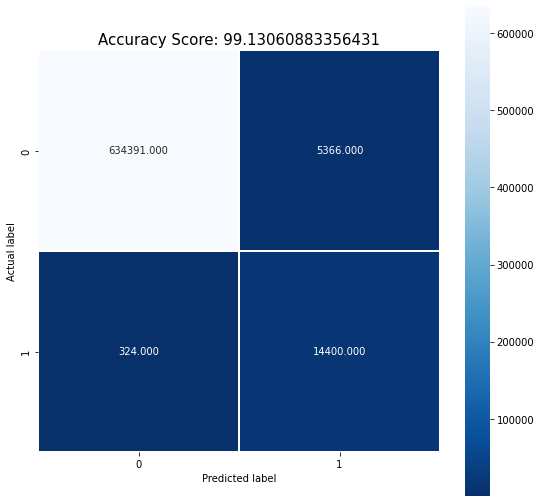

In [40]:
prediction_keras=model.predict(map_data)
length=len(prediction_keras)
y_label=np.argmax(y_val,axis=1)
predict_label_keras=np.argmax(prediction_keras,axis=1)

accuracy_keras=np.sum(y_label==predict_label_keras)/length * 100 
print("Validation Accuracy of Neural Network",accuracy_keras )
cm = show_confusion_matrix(y_test = water_veg_mask, y_pred = predict_label_keras, score = accuracy_keras)

In [41]:
ann_miou = get_miou(cm)
print(ann_miou)

0.8539425073806282
